## Predict Model

### 0. Initial Variables

In [5]:
from google.colab import auth
from googleapiclient.discovery import build


# The Google Drive Folder ID to read / write files
GOOGLE_DRIVE_FOLDER_ID = "1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1"

IMG_WIDTH = 128

PRE_PROCESSED_DATASET = "simpsons_pre_processed_data.npz"

# The train dataset
VAL_DATASET = "simpsons_val_data.npz"

# The test dataset
TEST_DATASET = "simpsons_test_data.npz"

FINAL_MODEL_FILENAME = f"simpsons_model_{IMG_WIDTH}.keras"

# Request permissions to access (read/write) the Google Drive Folder ID
auth.authenticate_user()
drive_service = build('drive', 'v3')

print(f"Successful initialization: Google Drive Id: {GOOGLE_DRIVE_FOLDER_ID}")

Successful initialization: Google Drive Id: 1GZ0NBMKvCcNAvPdW50j6OwcSasaoK8A1


In [31]:
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import psutil
from google.colab import auth
from googleapiclient.discovery import build
from tensorflow.keras.models import load_model as keras_load_model
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload


def load_dataset(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found the file '{filename}' in the folder '{folder_id}'.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download progress: {int(status.progress() * 100)}%")

    # Load NumPy data from the memory buffer
    fh.seek(0)
    data = np.load(fh, allow_pickle=True)

    X = data['X']
    y = data['y']
    labels = data['labels']

    print("Data successfully loaded.")
    return X, y, labels


def display_image(x_data, y_data, index, class_names=None):
    """
    Displays an image from the dataset with its numeric and text label.
    """
    img = x_data[index]
    label_raw = y_data[index]

    # 1. Handle One-Hot or Integer labels
    if hasattr(label_raw, '__len__') and len(label_raw) > 1:
        label_id = np.argmax(label_raw)
    else:
        label_id = int(np.array(label_raw).item())

    # 2. Setup Plot
    plt.figure(figsize=(5, 5))

    # If images were normalized (0-1 float), imshow handles it.
    # If they are 0-255 int, we ensure the type is uint8.
    if img.max() > 1.0 and img.dtype != np.uint8:
        img = img.astype(np.uint8)

    plt.imshow(img)

    # 3. Create Title (Numeric ID + Name)
    title = f"Index: {index} | Label ID: {label_id}"

    if class_names is not None:
        try:
            character_name = class_names[label_id]
            title += f"\nCharacter: {character_name.replace('_', ' ').title()}"
        except IndexError:
            title += "\n(Name not found in class_names)"

    plt.title(title)
    plt.axis('off')
    plt.show()

def show_colab_capabilities():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)

  ram_gb = psutil.virtual_memory().total / 1e9

  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)

  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')


def load_model_from_drive(folder_id, filename):
    """
    Searches for a model file in a specific Google Drive folder,
    downloads it locally, and loads it as a Keras model.
    """
    # 1. Search for the file in the specified Drive folder
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"Error: File '{filename}' not found in the specified Drive folder.")
        return None

    file_id = items[0]['id']
    local_path = filename  # Local path in the Colab environment

    # 2. Download the file from Google Drive
    print(f"Downloading model from Drive (ID: {file_id})...")
    request = drive_service.files().get_media(fileId=file_id)

    with io.FileIO(local_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            if status:
                print(f"   Download Progress: {int(status.progress() * 100)}%")

    # 3. Reconstruct the Keras model object
    try:
        # We use 'keras_load_model' (the alias) to ensure we don't call this function recursively
        model = keras_load_model(local_path)
        print(f"Model '{filename}' loaded successfully.")
        return model
    except Exception as e:
        print(f"Error loading model with Keras: {e}")
        return None

def load_dataset_from_drive(folder_id, filename):
    query = f"name = '{filename}' and '{folder_id}' in parents and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])

    if not items:
        print(f"No found '{filename}' in Drive.")
        return None, None, None

    file_id = items[0]['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download dataset: {int(status.progress() * 100)}%")

    fh.seek(0)
    data = np.load(fh, allow_pickle=True)
    print("Dataset sucessful loaded.")
    return data['X'], data['y'], data['labels']


import numpy as np
import matplotlib.pyplot as plt

def predict_and_visualize(model, image_array, real_label_name=None, class_names=None):
    """
    Predice y visualiza la imagen con sus probabilidades.
    """
    # 1. Validación de entrada
    if class_names is None:
        print("Error: Se requiere la lista class_names (le.classes_) para decodificar.")
        return

    # 2. Preparar imagen y Predecir
    # Si la imagen no tiene la dimensión de batch (H, W, C), se la añadimos
    img_batch = np.expand_dims(image_array, axis=0) if image_array.ndim == 3 else image_array

    predictions = model.predict(img_batch, verbose=0)[0]

    # Obtener Top 10 indices
    top_indices = predictions.argsort()[-10:][::-1]
    top_labels = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] for i in top_indices]

    predicted_idx = np.argmax(predictions)
    predicted_label = class_names[predicted_idx]

    # 3. Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # --- LADO IZQUIERDO: IMAGEN ---
    ax1.imshow(image_array)

    # Determinar color del título
    is_correct = False
    if real_label_name:
        is_correct = str(real_label_name).strip() == str(predicted_label).strip()

    title_color = 'green' if is_correct or real_label_name is None else 'red'

    title_text = f"Predicted: {predicted_label} ({predictions[predicted_idx]*100:.1f}%)"
    if real_label_name:
        title_text = f"Actual: {real_label_name}\n{title_text}"

    ax1.set_title(title_text, color=title_color, fontsize=14, fontweight='bold')
    ax1.axis('off')

    # --- LADO DERECHO: GRÁFICO DE BARRAS ---
    # Colorear la barra más alta
    colors = ['#2ecc71' if i == 0 else '#34495e' for i in range(len(top_labels))]

    bars = ax2.barh(top_labels, top_probs, color=colors)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1.1)
    ax2.set_title("Top 10 Confidence Scores", fontsize=12)

    # Añadir porcentaje de texto al final de cada barra
    for bar in bars:
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{width*100:.1f}%', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

#### Load Test dataset

In [34]:
model = load_model_from_drive(GOOGLE_DRIVE_FOLDER_ID, FINAL_MODEL_FILENAME)
X_test, y_test, _ = load_dataset(GOOGLE_DRIVE_FOLDER_ID, TEST_DATASET)

_, _, target_names = load_dataset(GOOGLE_DRIVE_FOLDER_ID, PRE_PROCESSED_DATASET)

Error: File 'simpsons_model_64.keras' not found in the specified Drive folder.


KeyboardInterrupt: 

import random

# Verificamos que los datos existan
if 'X_test' in locals() and X_test is not None:
    # Seleccionar un índice al azar
    idx = random.randint(0, len(X_test) - 1)
    
    # Obtener imagen y etiqueta
    sample_img = X_test[idx]
    
    # Obtener el nombre real (y_test suele ser One-Hot por el código que compartiste)
    label_id = np.argmax(y_test[idx]) if y_test[idx].ndim > 0 else int(y_test[idx])
    real_name = target_names[label_id]

    print(f"Analizando imagen del set de TEST índice: {idx}")
    predict_and_visualize(model, sample_img, real_label_name=real_name, class_names=target_names)
else:
    print("Error: El dataset X_test no está cargado. Ejecuta primero la carga de datos.")

Saving S29e05_3_29.PNG.webp to S29e05_3_29.PNG.webp

Procesando archivo: S29e05_3_29.PNG.webp


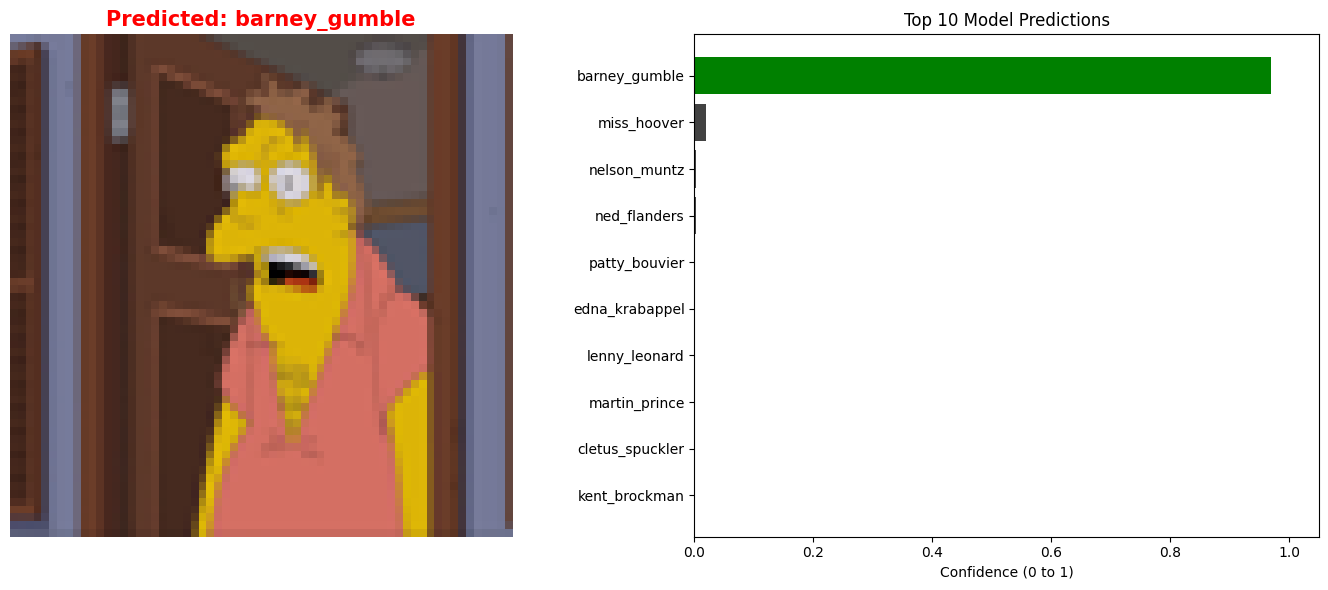

In [33]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()


for filename in uploaded.keys():
    # 1. Cargar imagen
    raw_img = Image.open(io.BytesIO(uploaded[filename]))

    # 2. FEATURE ENGINEERING (Espejo del entrenamiento)
    # A. Convertir a RGB (maneja PNGs transparentes o Grayscale)
    img_rgb = raw_img.convert('RGB')

    # B. Redimensionar a la arquitectura esperada (64x64)
    img_resized = img_rgb.resize((64, 64))

    # C. Convertir a array y Normalizar a [0, 1]
    img_normalized = np.array(img_resized).astype('float32') / 255.0

    # 3. Predicción y Visualización
    print(f"\nArchivo: {filename}")
    # Nota: real_label_name es None porque es una imagen nueva
    predict_and_visualize(
        model,
        img_normalized,
        real_label_name=None,
        class_names=target_names
    )